# Autoencoder


In [1]:
%%capture

from __future__ import print_function, division
from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
import sklearn
from matplotlib import pyplot as plt

import numpy as np
from torchvision import models, transforms
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torchvision.transforms import RandomVerticalFlip, RandomCrop

from albumentations import RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations import Compose
from albumentations.pytorch import ToTensor

import datetime
!pip install torchsummary
from torchsummary import summary


In [2]:
!pip install wandb

In [3]:
import wandb
import sys
sys.path.append('../src/')
sys.path.append('..')

import src.utils as my_utils
from train import *
from prepare_data import *

In [4]:
LR = 1e-5
BATCH_SIZE = 64
IMAGE_SIZE = 224

PATH = '/project/'
LOG_PATH = PATH +'logs/'
DATA_PATH = PATH + 'data/'
DEVICE = torch.device("cuda")
EPOCHS  = 200
#NAME = args.tags + '_'+ BASE + '_' + TYPE + '_' + str(LR) + '_' + str(NUM_CLASSES)
NAME = 'autoencoder'    

In [5]:
wandb.login()

True

In [6]:
import wandb
wandb.init(project="autoencoder", name='ae_big_1_5_norm', dir = LOG_PATH)


W&B Run: https://app.wandb.ai/nuvard/autoencoder/runs/ksene757

In [7]:
my_utils.test_device(DEVICE)

In [8]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.cuda.manual_seed(42)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Подготовка данных

In [9]:
transform = strong_aug(p=0.5)
train_loader, test_loader = prepare_dataset(csv_file_uf=DATA_PATH+'data_uf.csv',csv_file_dc=DATA_PATH+'data_dc.csv',
                                        root_dir=DATA_PATH, transform=transform, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, train_prop=0.8)


In [14]:
temp = next(iter(test_loader))

show!


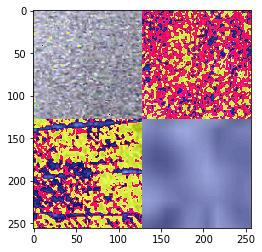

In [11]:
my_utils.show_batch_image(temp, a=0, b=3)
    

show!


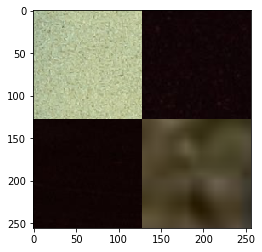

In [12]:
show_batch_image(temp,a = 3,b = 6)


## Обучение модели 


In [10]:
from tqdm import tqdm_notebook
import shutil

In [11]:
from torchvision.utils import save_image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x



class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 16, 1, stride=1, padding=0),  # b, 16, 10, 10
            nn.Conv2d(16, 3, 1, stride=1, padding=0),  # b, 16, 10, 10
            #nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 16, 1, stride=1, padding=0),  # b, 8, 15, 15
            nn.ConvTranspose2d(16, 6, 1, stride=1, padding=0),  # b, 16, 10, 
            #nn.ConvTranspose2d(3, 6, 1, stride=1, padding=0),  # b, 1, 28, 28
        )
    def encode(self, x):
        return self.encoder(x)
    
    def forward(self, x):
        x_1 = self.encoder(x)
        x = self.decoder(x_1)
        return (x_1, x)


model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                            )


In [12]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [13]:
summary(model, input_size = (6, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             112
            Conv2d-2          [-1, 3, 224, 224]              51
   ConvTranspose2d-3         [-1, 16, 224, 224]              64
   ConvTranspose2d-4          [-1, 6, 224, 224]             102
Total params: 329
Trainable params: 329
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.15
Forward/backward pass size (MB): 15.70
Params size (MB): 0.00
Estimated Total Size (MB): 16.85
----------------------------------------------------------------


In [14]:
def show_batch(image_batch, batch_size=4, a = 0, b = 3 ):
    """
    Show a sample grid image which contains some sample of test set result
    :param image_batch: The output batch of test set
    :param a: - first channel to draw
    :param b: - (b-1) is last channel to draw
    :return: PIL image of all images of the input batch
    """
    #inv_normalize = transforms.Normalize(
    #mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    #std=[1/0.229, 1/0.224, 1/0.255])
    
    to_pil =  transforms.ToPILImage()
    fs = []
    for i in range(batch_size):
        img = to_pil(image_batch[i,a:b,:,:].cpu())
        fs.append(img)
    x, y = fs[0].size
    ncol = int(np.ceil(np.sqrt(batch_size)))
    nrow = int(np.ceil(np.sqrt(batch_size)))
    cvs = Image.new('RGB', (x * ncol, y * nrow))
    for i in range(len(fs)):
        px, py = x * int(i / nrow), y * (i % nrow)
        cvs.paste((fs[i]), (px, py))
    return cvs 

In [15]:
def train():
    train_loss=0
    min_loss=10
    for idx, data in enumerate(tqdm(train_loader)):
        img, _ =  data.images.to(DEVICE), data.labels.to(DEVICE)
        # ===================forward=====================
        encoded, output = model(img)
        loss = criterion(output, img)
        train_loss+=loss
        if loss<min_loss:
            torch.save(model.state_dict(), LOG_PATH + '/trained_models/autoencoder.pth')
            min_loss = loss
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if  idx==0:
            i1 = show_batch(img,a = 3,b = 6)
            i2 = show_batch(output,a = 3,b = 6)
            i3 = show_batch(img,a = 0,b = 3)
            i4 = show_batch(output,a = 0,b = 3)
            i5 = show_batch(encoded)
            wandb.log({"input 3:6": [wandb.Image(i1)]}, step=epoch)
            wandb.log({"output 3:6": [wandb.Image(i2)]}, step=epoch)
            wandb.log({"input 1:3": [wandb.Image(i3)]}, step=epoch)
            wandb.log({"output 1:3": [wandb.Image(i4)]}, step=epoch)
            wandb.log({"encoded": [wandb.Image(i5)]}, step=epoch)
            #break
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, EPOCHS, train_loss/len(train_loader)))
    wandb.log({'loss': train_loss/len(train_loader)}, step=epoch)
    
def test():
    test_loss=0
    for idx, data in enumerate(tqdm(test_loader)):
        img, _ =  data.images.to(DEVICE), data.labels.to(DEVICE)
        # ===================forward=====================
        encoded, output = model(img)
        loss = criterion(output, img)
        test_loss += loss
        # ===================backward====================
        if  idx==0:
            i1 = show_batch(img,a = 3,b = 6)
            i2 = show_batch(output,a = 3,b = 6)
            i3 = show_batch(img,a = 0,b = 3)
            i4 = show_batch(output,a = 0,b = 3)
            i5 = show_batch(encoded)
            wandb.log({"test input 3:6": [wandb.Image(i1)]}, step=epoch)
            wandb.log({"test output 3:6": [wandb.Image(i2)]}, step=epoch)
            wandb.log({"test input 1:3": [wandb.Image(i3)]}, step=epoch)
            wandb.log({"test output 1:3": [wandb.Image(i4)]}, step=epoch)
            wandb.log({"test encoded": [wandb.Image(i5)]}, step=epoch)
            #break
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, EPOCHS, test_loss/len(test_loader)))
    wandb.log({'test loss': test_loss/len(test_loader)}, step=epoch)
    

In [16]:
%matplotlib inline
for epoch in range(EPOCHS):
    train()
    test()


epoch [1/200], loss:1.6384



epoch [1/200], loss:1.6761



epoch [2/200], loss:1.6424


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 11.17 GiB total capacity; 3.43 GiB already allocated; 33.69 MiB free; 78.86 MiB cached)

In [40]:
torch.save(model.state_dict(), LOG_PATH + '/trained_models/autoencoder.pth')

show!


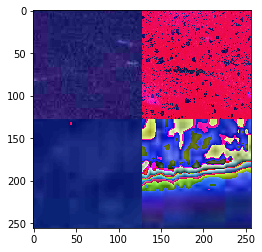

In [39]:
img = images[-1]
output = outputs[-1]
show_batch(img,a = 3,b = 6, name = 'out1_bef')


show!


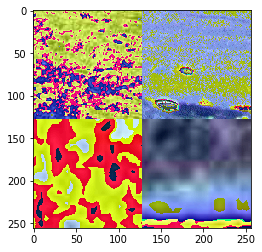

In [40]:
show_batch(img,a = 0,b = 3, name = 'out2_bef')


show!


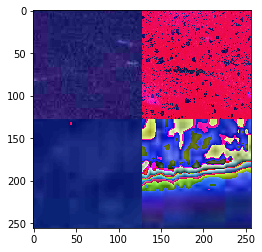

In [41]:
show_batch(img,a = 3,b = 6, name = 'out1_bef')


show!


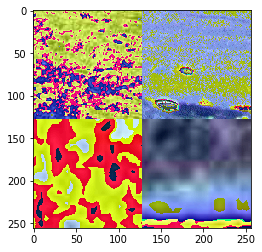

In [42]:
show_batch(img,a = 0,b = 3, name = 'out2_bef')